# Multi-Class Classification with iris flowers dataset

## Problem Description

In this tutorial we will use the standard machine learning problem called the [iris flowers dataset](http://archive.ics.uci.edu/ml/datasets/Iris).

This dataset is well studied and is a good problem for practicing on neural networks because all of the 4 input variables are numeric and have the same scale in centimeters. Each instance describes the properties of an observed flower measurements and the output variable is specific iris species.

This is a multi-class classification problem, meaning that there are more than two classes to be predicted, in fact there are three flower species. This is an important type of problem on which to practice with neural networks because the three class values require specialized handling.

The iris flower dataset is a well studied problem and as such we can expect to achieve a model accuracy in the range of 95% to 97%. This provides a good target to aim for when developing our models.

You can [download the iris flowers dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data) from the UCI Machine Learning repository and place it in your current working directory with the filename iris.csv

### Attribute Information:

1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class:
 * Iris Setosa
 * Iris Versicolour
 * Iris Virginica

## Import Classes and Functions

We can begin by importing all of the classes and functions we will need in this tutorial.

This includes both the functionality we require from Keras, but also data loading from [pandas](http://pandas.pydata.org/) as well as data preparation and model evaluation from [scikit-learn](http://scikit-learn.org/).

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Initialize Random Number Generator

Next we need to initialize the random number generator to a constant value (7).

This is important to ensure that the results we achieve from this model can be achieved again precisely. It ensures that the stochastic process of training a neural network model can be reproduced.

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## Load The Dataset

The dataset can be loaded directly. Because the output variable contains strings, it is easiest to load the data using pandas. We can then split the attributes (columns) into input variables (X) and output variables (Y).

In [3]:
# load dataset
dataframe = pd.read_csv("../datasets/iris.csv", header=None)

In [4]:
dataframe.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
dataset = dataframe.values
X_data = dataset[:,0:4].astype(float)
y_data = dataset[:,4]

In [6]:
print("X matrix shape", X_data.shape)
print("y matrix shape", y_data.shape)

X matrix shape (150, 4)
y matrix shape (150,)


# Encode The Output Variable

The output variable contains three different string values.

When modeling multi-class classification problems using neural networks, it is good practice to reshape the output attribute from a vector that contains values for each class value to be a matrix with a boolean for each class value and whether or not a given instance has that class value or not.

This is called [one hot encoding](https://en.wikipedia.org/wiki/One-hot) or creating dummy variables from a categorical variable.

For example, in this problem three class values are Iris-setosa, Iris-versicolor and Iris-virginica. If we had the observations:

* Iris-setosa
* Iris-versicolor
* Iris-virginica

We can turn this into a one-hot encoded binary matrix for each data instance that would look as follows:

<pre>

| Iris-setosa | Iris-versicolor | Iris-virginica |
|-------------|-----------------|----------------|
|      1      |        0        |       0        |
|-------------|-----------------|----------------|
|      0      |        1        |       0        |
|-------------|-----------------|----------------|
|      0      |        0        |       1        |

</pre>

We can do this by first encoding the strings consistently to integers using the scikit-learn class LabelEncoder, followed by one-hot encoding with the class OneHotEncoder.

In [7]:
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data).reshape(-1,1)
one_hot_encoder = OneHotEncoder()
y_data = one_hot_encoder.fit_transform(y_data).toarray()

## Define The Neural Network Model

The Keras library provides wrapper classes to allow you to use neural network models developed with Keras in scikit-learn.

There is a KerasClassifier class in Keras that can be used as an Estimator in scikit-learn, the base type of model in the library. The KerasClassifier takes the name of a function as an argument. This function must return the constructed neural network model, ready for training.

Below is a function that will create a baseline neural network for the iris classification problem. It creates a simple fully connected network with one hidden layer that contains 4 neurons, the same number of inputs (it could be any number of neurons).

The hidden layer uses a rectifier activation function which is a good practice. Because we used one-hot encoding for our iris dataset, the output layer must create 3 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

The network topology of this simple one-layer neural network can be summarized as:

* inputs -> [4 hidden nodes] -> 3 outputs

Note, that we use a sigmoid activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

Finally, the network uses the efficient ADAM gradient descent optimization algorithm with a logarithmic loss function, which is called categorical_crossentropy in Keras.

In [8]:
def baseline_model():
    model = Sequential()
    
    model.add(Dense(4, input_dim=4, kernel_initializer='normal'))
    model.add(Activation('sigmoid'))
    
    model.add(Dense(3, kernel_initializer='normal'))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Create the Model

In [9]:
model = baseline_model()

## Define training parameters

In [10]:
batch_size = 5
epochs = 200

## Train the model

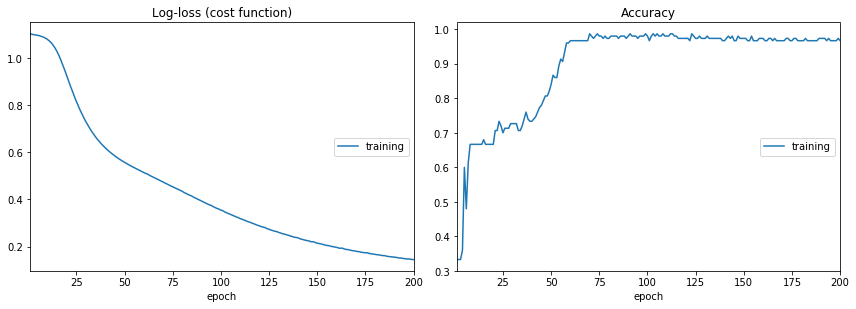

In [11]:
model.fit(X_data, y_data, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[PlotLossesKeras()])

## Evaluate the model with k-Fold Cross Validation

We can now create our KerasClassifier for use in scikit-learn.

We can also pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network. Here, we pass the number of epochs as 200 and batch size as 5 to use when training the model.  
Debugging is also turned off when training by setting verbose to 0.

In [12]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=epochs, batch_size=batch_size, verbose=0)

We can now evaluate the neural network model on our training data.

The scikit-learn has excellent capability to evaluate models using a suite of techniques.  
The gold standard for evaluating machine learning models is k-fold cross validation.

First we can define the model evaluation procedure.  
Here, we set the number of folds to be 10 (an excellent default) and to shuffle the data before partitioning it.

In [13]:
kfold = KFold(n_splits=10, shuffle=True, random_state=None)

Now we can evaluate our model (estimator) on our dataset (X_data and Y_data) using a 10-fold cross validation procedure (kfold).

Evaluating the model only takes approximately 10 seconds and returns an object that describes the evaluation of the 10 constructed models for each of the splits of the dataset.

In [14]:
results = cross_val_score(estimator, X_data, y_data, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 97.33% (3.27%)


The results are summarized as both the mean and standard deviation of the model accuracy on the dataset.  
This is a reasonable estimation of the performance of the model on unseen data.  
It is also within the realm of known top results for this problem.